In [1]:
#matched filtering， 信烁
import numpy as np
import scipy.interpolate
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import subprocess
from astropy.io import fits
from subprocess import Popen, PIPE
from mpl_toolkits.mplot3d import axes3d
from numpy import cos,sin
import h5py
import json

%matplotlib inline

In [81]:
#read GW data, see Gwave.ipynb for details
spin=0.5;
d1=-0.4;

#Observation angle, will be used to transform hbar to hTT 
PHI=0/180*np.pi  #azimuthal angle, in rad
THETA=45/180*np.pi  #latitude angle, in rad

#r0=20
#E=0.968693
#Lz=4.077016
e=0.5
p=6

print(e,p)
try:
    index, tau,t,r,th,phi,ut,ur,uth,uphi,F_t,F_r,F_th,F_phi=np.loadtxt \
('C:\\Users\\HP\\Documents\\Visual Studio 2015\\Projects\\RK4geo8_dt\\RK4geo8_dt\
\\trace_spin%.6f_d1%.6f_e%.6f_p%.6f.dat'%(spin,d1,e,p),unpack=True)
except:
    print('trace_spin%.6f_d1%.6f_e0%.6f_p%.6f.dat  does not exist'%(spin,d1,e,p))
    quit()

#qseudo_flat spacetime
x=[];
y=[];
z=[];
t_tau_dot=[]
z_tau_dot=[]
y_tau_dot=[]
x_tau_dot=[]
z_t_dot=[]
y_t_dot=[]
x_t_dot=[]
vr_tau_dot=[]
vth_tau_dot=[]
vphi_tau_dot=[]
vx_tau_dot=[]
vy_tau_dot=[]
vz_tau_dot=[]
x_t_2dot=[]
y_t_2dot=[]
z_t_2dot=[]


for i in np.arange(index.size):
    x.append(r[i]*np.sin(th[i])*np.cos(phi[i]));
    y.append(r[i]*np.sin(th[i])*np.sin(phi[i]));
    z.append(r[i]*np.cos(th[i]));
    t_tau_dot.append(ut[i])
    x_tau_dot.append(ur[i]*np.sin(th[i])*np.cos(phi[i]) + r[i]*np.cos(th[i])*np.cos(phi[i])*uth[i] - r[i]*np.sin(th[i])*np.sin(phi[i])*uphi[i] )
    y_tau_dot.append(ur[i]*np.sin(th[i])*np.sin(phi[i]) + r[i]*np.cos(th[i])*np.sin(phi[i])*uth[i] + r[i]*np.sin(th[i])*np.cos(phi[i])*uphi[i] )
    z_tau_dot.append(ur[i]*np.cos(th[i]) - r[i]*np.sin(th[i])*uth[i])
    x_t_dot.append(x_tau_dot[i]/t_tau_dot[i])
    y_t_dot.append(y_tau_dot[i]/t_tau_dot[i])
    z_t_dot.append(z_tau_dot[i]/t_tau_dot[i])
    
    vr_tau_dot.append( (F_r[i]*t_tau_dot[i]-ur[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )
    vth_tau_dot.append( (F_th[i]*t_tau_dot[i]-uth[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )
    vphi_tau_dot.append( (F_phi[i]*t_tau_dot[i]-uphi[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )
    
    vx_tau_dot.append( vr_tau_dot[i]*np.sin(th[i])*np.cos(phi[i]) + ur[i]/ut[i]*np.cos(th[i])*np.cos(phi[i])*uth[i] - ur[i]/ut[i]*np.sin(th[i])*np.sin(phi[i])*uphi[i]\
         + ur[i]*cos(th[i])*cos(phi[i])*uth[i]/ut[i] - r[i]*sin(th[i])*cos(phi[i])*uth[i]/ut[i]*uth[i] -r[i]*cos(th[i])*sin(phi[i])*uth[i]/ut[i]*uphi[i] +r[i]*cos(th[i])*cos(phi[i])*vth_tau_dot[i]  \
         - ur[i]*sin(th[i])*sin(phi[i])*uphi[i]/ut[i] - r[i]*cos(th[i])*sin(phi[i])*uphi[i]/ut[i]*uth[i] - r[i]*sin(th[i])*cos(phi[i])*uphi[i]/ut[i]*uphi[i] - r[i]*sin(th[i])*sin(phi[i])*vphi_tau_dot[i])
    
    vy_tau_dot.append( vr_tau_dot[i]*np.sin(th[i])*np.sin(phi[i]) + ur[i]/ut[i]*np.cos(th[i])*np.sin(phi[i])*uth[i] + ur[i]/ut[i]*np.sin(th[i])*np.cos(phi[i])*uphi[i]\
         + ur[i]*cos(th[i])*sin(phi[i])*uth[i]/ut[i] - r[i]*sin(th[i])*sin(phi[i])*uth[i]/ut[i]*uth[i] +r[i]*cos(th[i])*cos(phi[i])*uth[i]/ut[i]*uphi[i] +r[i]*cos(th[i])*sin(phi[i])*vth_tau_dot[i]  \
         + ur[i]*sin(th[i])*cos(phi[i])*uphi[i]/ut[i] + r[i]*cos(th[i])*cos(phi[i])*uphi[i]/ut[i]*uth[i] - r[i]*sin(th[i])*sin(phi[i])*uphi[i]/ut[i]*uphi[i] + r[i]*sin(th[i])*cos(phi[i])*vphi_tau_dot[i])
    
    vz_tau_dot.append( vr_tau_dot[i]*cos(th[i]) -ur[i]/ut[i]*sin(th[i])*uth[i] \
                     -ur[i]*sin(th[i])*uth[i]/ut[i] -r[i]*cos(th[i])*uth[i]/ut[i]*uth[i] - r[i]*sin(th[i])*vth_tau_dot[i] )
    
    x_t_2dot.append(vx_tau_dot[i]/ut[i])
    y_t_2dot.append(vy_tau_dot[i]/ut[i])
    z_t_2dot.append(vz_tau_dot[i]/ut[i])
    
#四极矩算法，在trace-reversed gauge的metric

hbar_xx=[]
hbar_yy=[]
hbar_zz=[]
hbar_xy=[]
hbar_yz=[]
hbar_xz=[]
for i in np.arange(index.size):
    hbar_xx.append(4*(x_t_dot[i]*x_t_dot[i]+x[i]*x_t_2dot[i]))
    hbar_yy.append(4*(y_t_dot[i]*y_t_dot[i]+y[i]*y_t_2dot[i]))
    hbar_zz.append(4*(z_t_dot[i]*z_t_dot[i]+z[i]*z_t_2dot[i]))
    hbar_xy.append(2*(y[i]*x_t_2dot[i]+y_t_2dot[i]*x[i]+2*y_t_dot[i]*x_t_dot[i]))
    hbar_yz.append(2*(y[i]*z_t_2dot[i]+y_t_2dot[i]*z[i]+2*y_t_dot[i]*z_t_dot[i]))
    hbar_xz.append(2*(z[i]*x_t_2dot[i]+z_t_2dot[i]*x[i]+2*z_t_dot[i]*x_t_dot[i]))
    
#由trace-reversed gauge转换到transverse traceless gauge

hTT_TT=[]
hTT_PP=[]
hTT_TP=[]
hTT_plus=[]
hTT_cross=[]

for i in np.arange(index.size):
    
    
    hTT_TT.append( np.cos(THETA)*np.cos(THETA)* (hbar_xx[i]*np.cos(PHI)*np.cos(PHI) + hbar_xy[i]*np.sin(2*PHI) + hbar_yy[i]*np.sin(PHI)*np.sin(PHI) )  +  hbar_zz[i]*np.sin(THETA)*np.sin(THETA)  -  np.sin(2*THETA)* (hbar_xz[i]*np.cos(PHI)+hbar_yz[i]*np.sin(PHI))  )
    hTT_TP.append( np.cos(THETA)* (-0.5*hbar_xx[i]*np.sin(2*PHI) + hbar_xy[i]*np.cos(2*PHI) + 0.5*hbar_yy[i]*np.sin(2*PHI))  +  np.sin(THETA)* (hbar_xz[i]*np.sin(PHI)-hbar_yz[i]*np.cos(PHI)) )
    hTT_PP.append( hbar_xx[i]*np.sin(PHI)*np.sin(PHI)  -  hbar_xy[i]*np.sin(2*PHI)  +  hbar_yy[i]*np.cos(PHI)*np.cos(PHI) )
    hTT_plus.append(0.5*(hTT_TT[i]-hTT_PP[i]))
    hTT_cross.append(hTT_TP[i])

0.5 6


In [83]:
#注意上面算出来的h还要*mu（mass ratio）/R（观测距离，也以M为单位）才是真的strain
#发现一个小问题，上面定义的数据类型大部分都是list，但是array才比较好用
#还要注意一点几何单位制和SI单位的转换

########转换单位
Grav=6.674e-11 #引力常数
clight=2.998e8 #光速
Msol=1.989e30  #太阳质量，以千克做单位

M=1e6 # clight*clight*clight/Grav/Msol/1 #中心天体质量，以太阳质量为单位

#把时间转换成秒
t_sec=t*M*Msol*Grav/clight/clight/clight
dt=t_sec[1]-t_sec[0]

#把pc距离转换成M为单位
R_pc=5e9  #以pc为单位的观测距离
R=R_pc*3.0857e16*clight*clight/Grav/M/Msol  #以中心天体质量为单位的，长度米与中心天体质量的换算是 1m/kg = clight*clight/G

#小天体的质量
mu=1e-5 #应该是以中心天体质量为单位的

hTT_plus_true=np.array(hTT_plus)*mu/R
hTT_cross_true=np.array(hTT_cross)*mu/R

########用于计算的波形，plus作为实部，cross作为虚部
mydata=hTT_plus_true+hTT_cross_true*1j

#采样频率
fs=1/dt

#做傅里叶变换，注意要除以采样频率才是真的amplitude
mytemp_fft=np.fft.fft(mydata)/fs

#变换后的频率序列,注意，只有前一半是正的频率
freq=np.fft.fftfreq(len(mydata),dt)

Text(0.5,0,'retarded time')

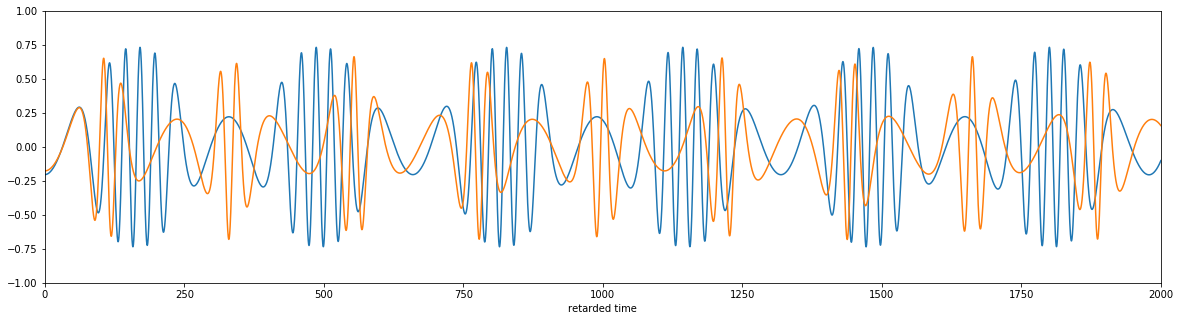

In [82]:
    
fig=plt.figure()
fig.set_size_inches(20, 5)
plt.xlim(0,2000)
plt.ylim(-1,1)
plt.plot(t,hTT_plus)
plt.plot(t,np.real(mydata)*R/mu)
plt.xlabel('retarded time')

Text(0.5,0,'retarded time')

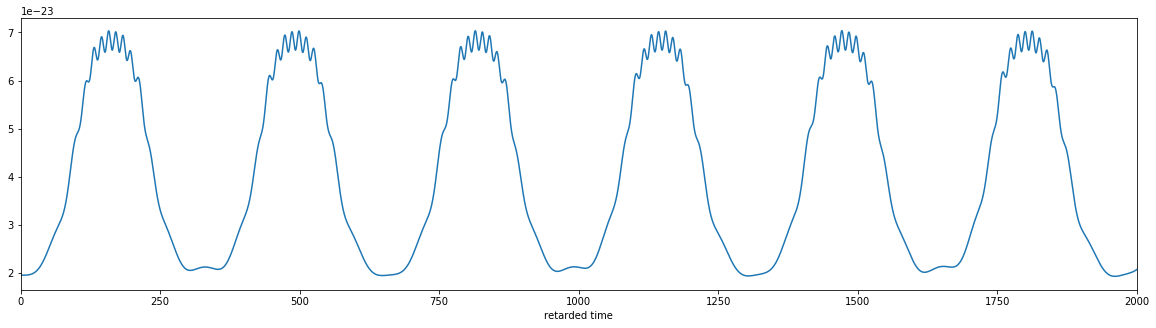

In [84]:
fig=plt.figure()
fig.set_size_inches(20, 5)
plt.xlim(0,2000)
#plt.ylim(-1,1)
plt.plot(t,np.abs(mydata))
plt.xlabel('retarded time')

In [2]:
def bracket(mydata,mytemp,dt):

    
    #两个时间序列长度要一样
    if len(mydata) != len(mytemp):
        print("inner product: length not match!")
        return

    #采样频率
    fs=1/dt

    #做傅里叶变换，注意要除以采样频率才是真的amplitude
    mydata_fft=np.fft.fft(mydata)/fs
    mytemp_fft=np.fft.fft(mytemp)/fs
    #变换后的频率序列,注意，只有前一半是正的频率
    freq=np.fft.fftfreq(len(mydata),dt)
    
    
    ##########LISA noise, reference: https://arxiv.org/abs/gr-qc/0607007v2
    u=2*np.pi*freq*50/3 #见reference（36）上面一段
    Sn=[]  #LISA noise
    for i in np.arange(freq.size/2):
        i=int(i)
        if i==0:
            Sn.append(1e10)
        elif(u[i]<0.25):
            Sn.append(8.08e-48/((2*np.pi*freq[i])**4) +5.52e-41 )
        else :
            Sn.append( (2.88e-48/((2*np.pi*freq[i])**4) +5.52e-41 ) *u[i]*u[i]/ ( (1+cos(u[i])*cos(u[i]) )*(1.0/3.0-2.0/u[i]/u[i]) + sin(u[i])**2 + 4*sin(u[i])*cos(u[i])/(u[i]**3) ) )


    ###########SNR
    SNR=0
    #SNspec=[]
    df=freq[1]-freq[0]
    for i in np.arange(freq.size/2):
        i=int(i)
        #SNspec.append(( mydata_fft[i]*np.conjugate(mytemp_fft[i]) + np.conjugate(mydata_fft[i])*mytemp_fft[i])/(Sn[i]))
        SNR=SNR+(( mydata_fft[i]*np.conjugate(mytemp_fft[i]) + np.conjugate(mydata_fft[i])*mytemp_fft[i])/(Sn[i]))*df
    #if len(SNspec)%2 == 0 :
        #plt.loglog(freq[np.arange(int(freq.size/2))],np.abs(SNspec))
    #else:
        #plt.loglog(freq[np.arange(1+int(freq.size/2))],np.abs(SNspec))
    #plt.xlim(1e-4,1e-1)
    #plt.ylim(1e-7*np.max(np.abs(SNspec)),np.max(np.abs(SNspec)))
    #print(SNR)
    return np.abs(SNR)

In [ ]:
bracket(mydata,mydata,dt)

1.4228195073822425

In [ ]:

f=h5py.File("test.hdf5","r+")
kerrbank=f['Kerr']
maxMatch=0

for tmpname in kerrbank.keys():
    print(tmpname+": e=%.6f, p=%.6f "%(kerrbank[tmpname].attrs["e"],kerrbank[tmpname].attrs["p"]))
    testtmp=kerrbank[tmpname]
    for i in np.arange(40):
        overlap=bracket(testtmp[0:50000],mydata[1000*i:50000+1000*i],dt)/(np.sqrt(bracket(testtmp[0:50000],testtmp[0:50000],dt)) * np.sqrt(bracket(mydata[1000*i:1000*i+50000],mydata[1000*i:1000*i+50000],dt ) ) )
        print("overlap: %.6f"%(overlap))
        if overlap>maxMatch:
            maxMatch=overlap
            besttmp=testtmp
            besttmpname=tmpname
            tagi=i
            for i in kerrbank[tmpname].attrs:
                print(i+": %f"%(kerrbank[tmpname].attrs[i]))
#    overlap=bracket(kerrbank[tmpname],mydata,dt)/(np.sqrt(bracket(kerrbank[tmpname],kerrbank[tmpname],dt)) * np.sqrt(bracket(mydata,mydata,dt ) ) )
#    print("overlap: %.6f"%(overlap))
#    if overlap>maxMatch:
#        maxMatch=overlap
#        besttmp=kerrbank[tmpname]
#        besttmpname=tmpname
#        for i in kerrbank[tmpname].attrs:
#            print(i+": %f"%(kerrbank[tmpname].attrs[i]))


f.close()

tmp1: e=0.400000, p=5.000000 
overlap: 0.043041
e: 0.400000
p: 5.000000
r0: 8.333333
spin: 0.500000
t0: 0.000000
phi0: 0.000000
th0: 1.570796
ur0: 0.000000
uth0: 0.000000
overlap: 0.011063
overlap: 0.034280
overlap: 0.006923
overlap: 0.030150
overlap: 0.021836
overlap: 0.000551
overlap: 0.002283
overlap: 0.007855
overlap: 0.041564
overlap: 0.043452
e: 0.400000
p: 5.000000
r0: 8.333333
spin: 0.500000
t0: 0.000000
phi0: 0.000000
th0: 1.570796
ur0: 0.000000
uth0: 0.000000
overlap: 0.029739
overlap: 0.029622
overlap: 0.021900
overlap: 0.036012
overlap: 0.009191
overlap: 0.019288
overlap: 0.006896
overlap: 0.020817
overlap: 0.032907
overlap: 0.014382
overlap: 0.035576
overlap: 0.009439
overlap: 0.045718
e: 0.400000
p: 5.000000
r0: 8.333333
spin: 0.500000
t0: 0.000000
phi0: 0.000000
th0: 1.570796
ur0: 0.000000
uth0: 0.000000
overlap: 0.003204
overlap: 0.035963
overlap: 0.003552
overlap: 0.029856
overlap: 0.018781
overlap: 0.003364
overlap: 0.004811
overlap: 0.006388
overlap: 0.042434
overlap

overlap: 0.015548
overlap: 0.020779
overlap: 0.021531
overlap: 0.033572
overlap: 0.006822
overlap: 0.002703
overlap: 0.013413
overlap: 0.021317
overlap: 0.029335
overlap: 0.007625
overlap: 0.004354
overlap: 0.037607
overlap: 0.035165
overlap: 0.025069
overlap: 0.014966
overlap: 0.018430
overlap: 0.035436
overlap: 0.027274
overlap: 0.013087
overlap: 0.002525
overlap: 0.011703
overlap: 0.040872
overlap: 0.027738
overlap: 0.008902
overlap: 0.023983
overlap: 0.023143
overlap: 0.031202
overlap: 0.001386
overlap: 0.008961
overlap: 0.019395
overlap: 0.024988
tmp108: e=0.450000, p=5.700000 
overlap: 0.126031
e: 0.450000
p: 5.700000
r0: 10.363636
spin: 0.500000
t0: 0.000000
phi0: 0.000000
th0: 1.570796
ur0: 0.000000
uth0: 0.000000
overlap: 0.071466
overlap: 0.048467
overlap: 0.149123
e: 0.450000
p: 5.700000
r0: 10.363636
spin: 0.500000
t0: 0.000000
phi0: 0.000000
th0: 1.570796
ur0: 0.000000
uth0: 0.000000
overlap: 0.021299
overlap: 0.075693
overlap: 0.092337
overlap: 0.053869
overlap: 0.103188


overlap: 0.010057
overlap: 0.005915
overlap: 0.040345
overlap: 0.000935
overlap: 0.017643
overlap: 0.003647
overlap: 0.035430
overlap: 0.004013
overlap: 0.010236
overlap: 0.017371
overlap: 0.011914
overlap: 0.023464
overlap: 0.017908
overlap: 0.010817
overlap: 0.014917
overlap: 0.024472
overlap: 0.026140
overlap: 0.020253
overlap: 0.004501
overlap: 0.013448
overlap: 0.030128
overlap: 0.001275
overlap: 0.017163
overlap: 0.009123
overlap: 0.010130
overlap: 0.038292
overlap: 0.000630
overlap: 0.016553
tmp117: e=0.450000, p=6.600000 
overlap: 0.189953
overlap: 0.044686
overlap: 0.049996
overlap: 0.034775
overlap: 0.201218
overlap: 0.116426
overlap: 0.026167
overlap: 0.053526
overlap: 0.121697
overlap: 0.197833
overlap: 0.058885
overlap: 0.044772
overlap: 0.011634
overlap: 0.192310
overlap: 0.148029
overlap: 0.002275
overlap: 0.070466
overlap: 0.080723
overlap: 0.197530
overlap: 0.074661
overlap: 0.047786
overlap: 0.025850
overlap: 0.170725
overlap: 0.171305
overlap: 0.026778
overlap: 0.060

overlap: 0.002726
overlap: 0.014001
overlap: 0.049038
overlap: 0.044524
overlap: 0.013513
overlap: 0.029087
overlap: 0.011168
overlap: 0.046356
overlap: 0.002295
overlap: 0.001451
overlap: 0.001995
overlap: 0.001053
overlap: 0.056907
overlap: 0.016011
overlap: 0.007952
overlap: 0.027052
overlap: 0.039865
overlap: 0.042654
overlap: 0.027650
overlap: 0.004231
overlap: 0.020898
overlap: 0.014499
overlap: 0.024012
overlap: 0.003005
overlap: 0.016026
overlap: 0.051162
overlap: 0.042498
overlap: 0.013330
overlap: 0.025862
overlap: 0.013979
overlap: 0.050166
overlap: 0.005175
tmp127: e=0.460000, p=5.600000 
overlap: 0.024568
overlap: 0.026859
overlap: 0.005287
overlap: 0.026334
overlap: 0.014369
overlap: 0.004839
overlap: 0.000489
overlap: 0.032589
overlap: 0.030203
overlap: 0.010285
overlap: 0.043124
overlap: 0.034133
overlap: 0.003907
overlap: 0.020744
overlap: 0.006813
overlap: 0.007993
overlap: 0.019266
overlap: 0.020985
overlap: 0.021557
overlap: 0.003324
overlap: 0.046851
overlap: 0.031

overlap: 0.005525
overlap: 0.055456
overlap: 0.059632
overlap: 0.009854
overlap: 0.003982
overlap: 0.037541
overlap: 0.072127
overlap: 0.036323
overlap: 0.010130
overlap: 0.006018
overlap: 0.043732
overlap: 0.052448
overlap: 0.017270
overlap: 0.011696
overlap: 0.025491
overlap: 0.071064
overlap: 0.049966
overlap: 0.001274
overlap: 0.000331
overlap: 0.049065
overlap: 0.058818
overlap: 0.015303
overlap: 0.008636
overlap: 0.009066
overlap: 0.057895
overlap: 0.056337
overlap: 0.005195
overlap: 0.002248
overlap: 0.043160
overlap: 0.071426
overlap: 0.031630
overlap: 0.011128
overlap: 0.009523
overlap: 0.046864
overlap: 0.049550
overlap: 0.013100
tmp137: e=0.460000, p=6.600000 
overlap: 0.049200
overlap: 0.039715
overlap: 0.011583
overlap: 0.039362
overlap: 0.028694
overlap: 0.033390
overlap: 0.074829
overlap: 0.065704
overlap: 0.043379
overlap: 0.021690
overlap: 0.024029
overlap: 0.019250
overlap: 0.057304
overlap: 0.035112
overlap: 0.056480
overlap: 0.075902
overlap: 0.056388
overlap: 0.013

overlap: 0.092824
overlap: 0.086538
overlap: 0.032100
overlap: 0.025955
overlap: 0.079834
overlap: 0.085465
overlap: 0.068909
overlap: 0.012483
overlap: 0.057041
overlap: 0.093719
overlap: 0.085309
overlap: 0.051523
overlap: 0.028346
overlap: 0.079083
overlap: 0.099502
overlap: 0.066810
overlap: 0.021331
overlap: 0.046545
overlap: 0.089019
overlap: 0.090081
overlap: 0.052061
overlap: 0.008387
overlap: 0.075504
overlap: 0.092115
overlap: 0.076773
overlap: 0.017186
overlap: 0.041227
overlap: 0.090228
overlap: 0.084411
overlap: 0.057421
overlap: 0.007494
overlap: 0.072901
overlap: 0.096326
overlap: 0.075922
overlap: 0.035405
overlap: 0.043171
overlap: 0.086482
overlap: 0.097222
overlap: 0.056752
overlap: 0.005504
tmp147: e=0.470000, p=5.600000 
overlap: 0.011225
overlap: 0.007777
overlap: 0.030199
overlap: 0.001104
overlap: 0.004467
overlap: 0.029014
overlap: 0.005465
overlap: 0.004006
overlap: 0.000280
overlap: 0.022866
overlap: 0.009346
overlap: 0.005927
overlap: 0.034184
overlap: 0.011

overlap: 0.028076
overlap: 0.013372
overlap: 0.006927
overlap: 0.010624
overlap: 0.038372
overlap: 0.034954
overlap: 0.002097
overlap: 0.004464
overlap: 0.025580
overlap: 0.029027
overlap: 0.012036
overlap: 0.004466
overlap: 0.011310
overlap: 0.015666
overlap: 0.030013
overlap: 0.009889
tmp156: e=0.470000, p=6.500000 
overlap: 0.139313
overlap: 0.099674
overlap: 0.069380
overlap: 0.154288
overlap: 0.030296
overlap: 0.144992
overlap: 0.031150
overlap: 0.136591
overlap: 0.125585
overlap: 0.105474
overlap: 0.118759
overlap: 0.045281
overlap: 0.166391
overlap: 0.010921
overlap: 0.155821
overlap: 0.057553
overlap: 0.109426
overlap: 0.138863
overlap: 0.069749
overlap: 0.131825
overlap: 0.016135
overlap: 0.170627
overlap: 0.063019
overlap: 0.144719
overlap: 0.084826
overlap: 0.085480
overlap: 0.150726
overlap: 0.049187
overlap: 0.138772
overlap: 0.016587
overlap: 0.149859
overlap: 0.110626
overlap: 0.116532
overlap: 0.105612
overlap: 0.062694
overlap: 0.168782
overlap: 0.009630
overlap: 0.152

overlap: 0.041017
overlap: 0.034423
overlap: 0.031294
overlap: 0.016867
overlap: 0.014789
overlap: 0.022974
overlap: 0.007544
overlap: 0.012507
overlap: 0.009522
overlap: 0.021022
overlap: 0.037937
overlap: 0.030577
overlap: 0.032769
overlap: 0.033441
overlap: 0.028520
overlap: 0.028871
overlap: 0.008886
overlap: 0.006417
overlap: 0.011208
overlap: 0.010641
tmp166: e=0.480000, p=5.500000 
overlap: 0.000954
overlap: 0.005394
overlap: 0.004058
overlap: 0.010653
overlap: 0.008482
overlap: 0.017156
overlap: 0.008076
overlap: 0.001423
overlap: 0.002596
overlap: 0.007106
overlap: 0.002980
overlap: 0.003163
overlap: 0.002368
overlap: 0.011719
overlap: 0.004500
overlap: 0.009196
overlap: 0.005596
overlap: 0.006040
overlap: 0.010028
overlap: 0.008702
overlap: 0.004754
overlap: 0.008364
overlap: 0.003362
overlap: 0.002748
overlap: 0.005213
overlap: 0.003530
overlap: 0.011155
overlap: 0.007993
overlap: 0.017039
overlap: 0.006900
overlap: 0.001027
overlap: 0.003070
overlap: 0.007209
overlap: 0.001

overlap: 0.011215
overlap: 0.047310
overlap: 0.039241
overlap: 0.024098
overlap: 0.016260
overlap: 0.000035
overlap: 0.037659
overlap: 0.029021
overlap: 0.015689
overlap: 0.003243
overlap: 0.028099
overlap: 0.051529
overlap: 0.019438
overlap: 0.014553
overlap: 0.014014
overlap: 0.028900
overlap: 0.028245
overlap: 0.018501
overlap: 0.006326
overlap: 0.009187
overlap: 0.038763
overlap: 0.024767
overlap: 0.010539
overlap: 0.003016
tmp176: e=0.480000, p=6.500000 
overlap: 0.029104
overlap: 0.035872
overlap: 0.022361
overlap: 0.011505
overlap: 0.039965
overlap: 0.037822
overlap: 0.004656
overlap: 0.023550
overlap: 0.021936
overlap: 0.022657
overlap: 0.035415
overlap: 0.022622
overlap: 0.004674
overlap: 0.027658
overlap: 0.047692
overlap: 0.025102
overlap: 0.029720
overlap: 0.023252
overlap: 0.022292
overlap: 0.031595
overlap: 0.012104
overlap: 0.015393
overlap: 0.021984
overlap: 0.030910
overlap: 0.029602
overlap: 0.025033
overlap: 0.015380
overlap: 0.038875
overlap: 0.040776
overlap: 0.012

overlap: 0.069657
overlap: 0.077856
overlap: 0.052066
overlap: 0.006242
overlap: 0.026949
overlap: 0.048295
overlap: 0.056695
overlap: 0.051515
overlap: 0.022732
overlap: 0.045060
overlap: 0.082070
overlap: 0.071500
overlap: 0.031185
overlap: 0.040746
overlap: 0.067475
overlap: 0.058363
overlap: 0.034214
overlap: 0.011404
overlap: 0.023225
overlap: 0.063163
overlap: 0.068448
overlap: 0.049301
overlap: 0.010406
overlap: 0.076477
overlap: 0.077996
overlap: 0.046213
overlap: 0.005695
overlap: 0.039222
tmp186: e=0.490000, p=5.500000 
overlap: 0.043383
overlap: 0.017286
overlap: 0.005887
overlap: 0.046299
overlap: 0.009103
overlap: 0.016331
overlap: 0.045254
overlap: 0.005642
overlap: 0.038582
overlap: 0.030683
overlap: 0.038405
overlap: 0.029858
overlap: 0.013777
overlap: 0.046252
overlap: 0.010232
overlap: 0.001701
overlap: 0.044025
overlap: 0.000669
overlap: 0.030556
overlap: 0.040198
overlap: 0.019485
overlap: 0.038215
overlap: 0.023861
overlap: 0.044412
overlap: 0.017734
overlap: 0.004

overlap: 0.067144
overlap: 0.063873
overlap: 0.096470
overlap: 0.030975
overlap: 0.131553
overlap: 0.033525
overlap: 0.122613
overlap: 0.060597
overlap: 0.113275
overlap: 0.096546
overlap: 0.054330
overlap: 0.095965
overlap: 0.005853
overlap: 0.111303
overlap: 0.057665
overlap: 0.088837
overlap: 0.080946
overlap: 0.072375
overlap: 0.128935
overlap: 0.035279
overlap: 0.115679
overlap: 0.009862
overlap: 0.110203
overlap: 0.058027
overlap: 0.072138
overlap: 0.090247
overlap: 0.044417
overlap: 0.133599
overlap: 0.019528
overlap: 0.123889
overlap: 0.046214
overlap: 0.121807
tmp196: e=0.490000, p=6.500000 
overlap: 0.047154
overlap: 0.034934
overlap: 0.102384
overlap: 0.024860
overlap: 0.020985
overlap: 0.009735
overlap: 0.053576
overlap: 0.024414
overlap: 0.090557
overlap: 0.033988
overlap: 0.056793


In [59]:
print(maxMatch)

0.510254380021


In [ ]:
f=h5py.File("test.hdf5","r+")
kerrbank=f['Kerr']
i=tagi
fig=plt.figure()
fig.set_size_inches(20, 5)
plt.xlim(3000,5000)
plt.ylim(-1,1)
plt.plot(t[0*1000:50000+0*1000],hTT_plus[i*1000:50000+i*1000],label="$\delta_1$=%.2f"%(d1))
plt.plot(t,np.real(kerrbank[besttmpname]),label="Kerr best match: e=%.2f p=%.2f"%(f['/Kerr/'+besttmpname].attrs['e'],f['/Kerr/'+besttmpname].attrs['p']))
plt.xlabel('retarded time')
plt.legend()
f.close()

In [5]:
delayt, delayreal, delayimag=np.loadtxt('C:/Users/HP/downloads/with_delay.dat',unpack=True)

In [7]:
undelayt,undelayreal, undelayimag=np.loadtxt('C:/Users/HP/downloads/without_delay.dat',unpack=True)

In [12]:
delaydata=delayreal+1j*delayimag

In [13]:
undelaydata=undelayreal+1j*undelayimag

In [15]:
bracket(undelaydata,delaydata,1)/np.sqrt(bracket(undelaydata,undelaydata,1)*bracket(delaydata,delaydata,1))

0.13642491163819115

In [20]:
testtmp=undelaydata
mydata=delaydata
maxMatch=0
dt=1

In [27]:
for i in np.arange(300):
    overlap=bracket(testtmp[0:5000],mydata[10*i:5000+10*i],dt)/(np.sqrt(bracket(testtmp[0:5000],testtmp[0:5000],dt)) * np.sqrt(bracket(mydata[10*i:10*i+5000],mydata[10*i:10*i+5000],dt ) ) )
    print("overlap: %.6f"%(overlap))
    if overlap>maxMatch:
        maxMatch=overlap
        tagi=i
        print(i)

overlap: 0.131768
overlap: 0.283971
overlap: 0.143396
overlap: 0.174365
overlap: 0.113862
overlap: 0.174825
overlap: 0.163091
overlap: 0.075550
overlap: 0.084682
overlap: 0.106932
overlap: 0.087687
overlap: 0.065623
overlap: 0.047317
overlap: 0.024631
overlap: 0.056009
overlap: 0.088281
overlap: 0.045818
overlap: 0.046364
overlap: 0.150000
overlap: 0.148346
overlap: 0.100315
overlap: 0.126666
overlap: 0.055499
overlap: 0.010582
overlap: 0.254193
overlap: 0.287787
overlap: 0.116101
overlap: 0.197247
overlap: 0.270981
overlap: 0.116165
overlap: 0.073686
overlap: 0.248270
overlap: 0.067061
overlap: 0.276529
overlap: 0.230069
overlap: 0.066293
overlap: 0.022130
overlap: 0.044177
overlap: 0.048099
overlap: 0.081038
overlap: 0.097322
overlap: 0.039350
overlap: 0.062917
overlap: 0.081441
overlap: 0.107112
overlap: 0.005634
overlap: 0.031832
overlap: 0.150981
overlap: 0.060173
overlap: 0.036115
overlap: 0.123209
overlap: 0.202417
overlap: 0.044566
overlap: 0.020922
overlap: 0.232332
overlap: 0

In [24]:
len(mydata)

8000

In [25]:
len(testtmp)

8000

D:\ProgramFiles\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


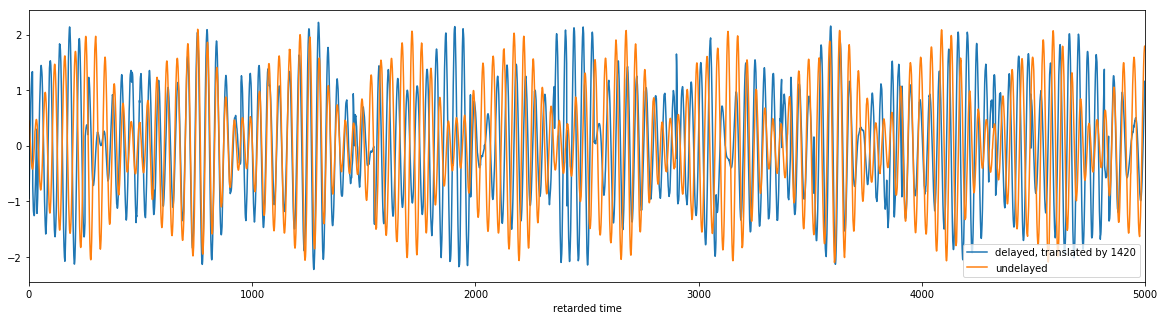

In [30]:
i=tagi
t=delayt
fig=plt.figure()
fig.set_size_inches(20, 5)
plt.xlim(0,5000)
#plt.ylim(-1,1)
plt.plot(t[0*10:5000+0*10],mydata[i*10:5000+i*10],label="delayed, translated by %d"%(tagi*10))
plt.plot(t,testtmp,label="undelayed")
plt.xlabel('retarded time')
plt.legend()

In [69]:
#Sourabh的unscale，图方便我就放这了。。。
import numpy as np
from astropy.io import fits
from subprocess import Popen, PIPE
import sys

deftype = 6#int(sys.argv[1])
if(deftype==1):
    our_file = fits.open('Trf_Johannsen_a13.fits') # THIS IS FOR JOHANNSEN ALPHA_13 
elif(deftype==2):
    our_file = fits.open('Trf_Johannsen_a22.fits') # THIS IS FOR JOHANNSEN ALPHA_22
elif(deftype==3):
    our_file = fits.open('Trf_Johannsen_e3.fits') 
elif(deftype==4):
    our_file = fits.open('Trf_KRZ_d1.fits') # THIS IS FOR KRZ d1 
elif(deftype==6):
    our_file = fits.open('Trf_KRZ_d2.fits') # THIS IS FOR KRZ d2    
else:
    print("deftype doesn't match with any deformation parameter")
#our_file = fits.open('Trf_ordered_e_0.00e+00.a22_0.00e+00.a52_0.00e+00.fits')
spindpgrid = our_file[1].data

spin = 0.8#float(sys.argv[2])
dpscaled = -0.21456463690229233 #float(sys.argv[3])

for j in np.arange(29):
    if((spin<spindpgrid[j+1][0]) and (spin>spindpgrid[j][0])):
            #print spin[i][0],spindpgrid[j][0], spindpgrid[j+1][0]
            #for k in np.arange(dpind):
            deflim=0.0
            ifaca = (spin-spindpgrid[j][0])/(spindpgrid[j+1][0]-spindpgrid[j][0])
            if(dpscaled < 0):
                deflim = spindpgrid[j][1][0] + ifaca*(spindpgrid[j+1][1][0]-spindpgrid[j][1][0])
                dpcorrect = -dpscaled*deflim
            else:
                deflim = spindpgrid[j][1][29] + ifaca*(spindpgrid[j+1][1][29]-spindpgrid[j][1][29])
                dpcorrect = dpscaled*deflim
                        
print(dpcorrect)


-1.0


In [68]:
2*-0.10728231845114617

-0.21456463690229233